# 初期設定

In [15]:
from typing import *
import os
from glob import glob
from datetime import datetime
import math
import random as rn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nptyping import NDArray
from minepy import MINE as Mine
from crypto_data_fetcher.gmo import GmoFetcher
from scipy.stats import ttest_1samp
import talib
import shap
import numba

# 機械学習ライブラリ
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, KFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report, f1_score, r2_score
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, LogisticRegression
from sklearn.ensemble import BaggingRegressor
import joblib
import optuna

sns.set_style('whitegrid')
colors = ['#de3838', '#007bc3', '#ffd12a']
markers = ['o', 'x', ',']
%config InlineBackend.figure_formats = ['svg']

np.random.seed(123)
rn.seed(123)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# データ読み込み

In [16]:
df = pd.read_csv('ohlcv_15min_1112.csv')
display(df)

df_btc_7_5m = pd.read_csv('ohlcv_7.5min_1112_btc.csv')
display(df_btc_7_5m)
df_btc_5m = pd.read_csv('ohlcv_5min_1112_btc.csv')
display(df_btc_5m)
df_btc_2_5m = pd.read_csv('ohlcv_2.5min_1112_btc.csv')
display(df_btc_2_5m)

# ETH
df_eth = pd.read_csv('ohlcv_15min_1112_eth.csv')
display(df_eth)

df_eth_5m = pd.read_csv('ohlcv_5min_1112_eth.csv')
display(df_eth_5m)

# XRP
df_xrp = pd.read_csv('ohlcv_15min_1112_xrp.csv')
display(df_xrp)




,timestamp,open,high,low,close,volume
0,2019-10-01 00:00:00+00:00,8297.5,8340.0,8227.0,8253.0,15208339
1,2019-10-01 00:15:00+00:00,8253.0,8264.0,8226.0,8231.5,6727155
2,2019-10-01 00:30:00+00:00,8231.5,8236.0,8214.0,8236.0,7055839
3,2019-10-01 00:45:00+00:00,8236.0,8236.0,8220.0,8225.0,2851351
4,2019-10-01 01:00:00+00:00,8225.0,8235.0,8199.0,8228.5,8568631
...,...,...,...,...,...,...
74299,2021-11-12 22:45:00+00:00,64093.0,64099.0,63725.5,63948.5,31085187
74300,2021-11-12 23:00:00+00:00,63948.5,64043.0,63948.5,64015.5,9639935
74301,2021-11-12 23:15:00+00:00,64015.5,64068.5,63921.5,63994.0,9049677
74302,2021-11-12 23:30:00+00:00,63994.0,64092.5,63867.0,63867.0,12635332


,timestamp,open,high,low,close,volume
0,2019-10-01 00:00:00+00:00,8297.5,8340.0,8252.5,8253.0,11404793
1,2019-10-01 00:07:30+00:00,8253.0,8260.5,8227.0,8253.0,3803546
2,2019-10-01 00:15:00+00:00,8253.0,8264.0,8240.5,8240.5,3486169
3,2019-10-01 00:22:30+00:00,8241.0,8243.0,8226.0,8231.5,3240986
4,2019-10-01 00:30:00+00:00,8231.5,8231.5,8214.0,8215.5,4429743
...,...,...,...,...,...,...
148603,2021-11-12 23:22:30+00:00,63921.5,64011.5,63921.5,63994.0,4634515
148604,2021-11-12 23:30:00+00:00,63994.0,64092.5,63994.0,64050.0,3722491
148605,2021-11-12 23:37:30+00:00,64050.5,64050.5,63867.0,63867.0,8912841
148606,2021-11-12 23:45:00+00:00,63867.0,64124.0,63867.0,64044.5,7931867


,timestamp,open,high,low,close,volume
0,2019-10-01 00:00:00+00:00,8297.5,8340.0,8253.5,8262.0,9050902
1,2019-10-01 00:05:00+00:00,8262.0,8266.5,8251.0,8252.5,3755054
2,2019-10-01 00:10:00+00:00,8252.5,8253.5,8227.0,8253.0,2402383
3,2019-10-01 00:15:00+00:00,8253.0,8264.0,8253.0,8255.5,2478222
4,2019-10-01 00:20:00+00:00,8252.5,8255.0,8226.0,8234.5,2964025
...,...,...,...,...,...,...
222907,2021-11-12 23:35:00+00:00,64070.0,64070.0,63986.5,63990.5,1646441
222908,2021-11-12 23:40:00+00:00,63990.0,64032.0,63867.0,63867.0,8149424
222909,2021-11-12 23:45:00+00:00,63867.0,64050.0,63867.0,64050.0,4192554
222910,2021-11-12 23:50:00+00:00,64050.0,64350.0,64023.0,64275.5,16205695


,timestamp,open,high,low,close,volume
0,2019-10-01 00:00:00+00:00,8297.5,8340.0,8285.0,8287.5,4718824
1,2019-10-01 00:02:30+00:00,8287.5,8287.5,8253.5,8262.0,4332078
2,2019-10-01 00:05:00+00:00,8262.0,8266.5,8252.5,8253.0,2353891
3,2019-10-01 00:07:30+00:00,8253.0,8260.5,8251.0,8252.5,1401163
4,2019-10-01 00:10:00+00:00,8252.5,8253.0,8227.0,8243.5,1461908
...,...,...,...,...,...,...
445818,2021-11-12 23:47:30+00:00,63978.0,64050.0,63978.0,64050.0,2310348
445819,2021-11-12 23:50:00+00:00,64050.0,64124.0,64023.0,64044.5,3739313
445820,2021-11-12 23:52:30+00:00,64045.0,64350.0,64044.5,64275.5,12466382
445821,2021-11-12 23:55:00+00:00,64276.0,64400.0,64256.0,64341.0,6289006


,timestamp,open,high,low,close,volume
0,2019-10-01 00:00:00+00:00,181.25,181.70,179.55,180.10,911858
1,2019-10-01 00:15:00+00:00,180.15,180.35,179.05,179.90,1259103
2,2019-10-01 00:30:00+00:00,179.90,179.90,178.65,179.05,623606
3,2019-10-01 00:45:00+00:00,179.10,179.10,178.65,179.05,368355
4,2019-10-01 01:00:00+00:00,179.05,179.15,178.30,178.80,617389
...,...,...,...,...,...,...
74299,2021-11-12 22:45:00+00:00,4650.95,4650.95,4633.10,4643.95,7223354
74300,2021-11-12 23:00:00+00:00,4644.10,4656.95,4644.05,4656.90,4702013
74301,2021-11-12 23:15:00+00:00,4656.90,4660.25,4652.15,4656.95,2407601
74302,2021-11-12 23:30:00+00:00,4658.75,4671.10,4644.35,4648.85,7966782


,timestamp,open,high,low,close,volume
0,2019-10-01 00:00:00+00:00,181.25,181.70,180.05,180.20,608289
1,2019-10-01 00:05:00+00:00,180.20,180.55,179.80,179.90,152752
2,2019-10-01 00:10:00+00:00,179.90,180.10,179.55,180.10,150817
3,2019-10-01 00:15:00+00:00,180.15,180.35,180.00,180.00,356446
4,2019-10-01 00:20:00+00:00,179.65,179.75,179.05,179.45,493927
...,...,...,...,...,...,...
222907,2021-11-12 23:35:00+00:00,4665.75,4665.80,4660.10,4661.35,935174
222908,2021-11-12 23:40:00+00:00,4661.40,4663.80,4644.35,4648.85,2729555
222909,2021-11-12 23:45:00+00:00,4648.80,4657.20,4648.35,4657.15,2367563
222910,2021-11-12 23:50:00+00:00,4657.20,4679.05,4655.25,4672.00,6821172


,timestamp,open,high,low,close,volume
0,2019-10-01 00:00:00+00:00,0.2572,0.2578,0.2546,0.2553,722844
1,2019-10-01 00:15:00+00:00,0.2554,0.2554,0.2545,0.2551,276482
2,2019-10-01 00:30:00+00:00,0.2549,0.2550,0.2541,0.2545,388315
3,2019-10-01 00:45:00+00:00,0.2544,0.2547,0.2542,0.2542,845748
4,2019-10-01 01:00:00+00:00,0.2542,0.2543,0.2530,0.2539,340968
...,...,...,...,...,...,...
74299,2021-11-12 22:45:00+00:00,1.1927,1.1927,1.1865,1.1919,1350897
74300,2021-11-12 23:00:00+00:00,1.1920,1.1935,1.1898,1.1905,763830
74301,2021-11-12 23:15:00+00:00,1.1905,1.1940,1.1885,1.1897,1898398
74302,2021-11-12 23:30:00+00:00,1.1898,1.1916,1.1873,1.1876,1634083


In [17]:
df['fee'] = -0.00025
display(df)
df.to_pickle('df_ohlcv_with_fee.pkl')

,timestamp,open,high,low,close,volume,fee
0,2019-10-01 00:00:00+00:00,8297.5,8340.0,8227.0,8253.0,15208339,-0.00025
1,2019-10-01 00:15:00+00:00,8253.0,8264.0,8226.0,8231.5,6727155,-0.00025
2,2019-10-01 00:30:00+00:00,8231.5,8236.0,8214.0,8236.0,7055839,-0.00025
3,2019-10-01 00:45:00+00:00,8236.0,8236.0,8220.0,8225.0,2851351,-0.00025
4,2019-10-01 01:00:00+00:00,8225.0,8235.0,8199.0,8228.5,8568631,-0.00025
...,...,...,...,...,...,...,...
74299,2021-11-12 22:45:00+00:00,64093.0,64099.0,63725.5,63948.5,31085187,-0.00025
74300,2021-11-12 23:00:00+00:00,63948.5,64043.0,63948.5,64015.5,9639935,-0.00025
74301,2021-11-12 23:15:00+00:00,64015.5,64068.5,63921.5,63994.0,9049677,-0.00025
74302,2021-11-12 23:30:00+00:00,63994.0,64092.5,63867.0,63867.0,12635332,-0.00025


# 特徴量生成

In [18]:
def up_hige_size(df):
    """上ヒゲの大きさ"""
    df = df.copy()
    uphige = np.zeros(len(df))
    high = df.high.values
    close = df.close.values
    open_ = df.open.values
    # close とopenの高い方を判定
    close_or_open = df.open.values - df.close.values
    close_or_open_sign = np.sign(close_or_open)
    close_or_open_sign = np.where(close_or_open_sign == 0, 1, close_or_open_sign)
    # 陽線
    for i in range(len(close_or_open_sign)):
        sig = close_or_open_sign[i]
        h = high[i]
        o = open_[i]
        c = close[i]
        if sig == 1:
            uphige[i] = (h - o) / c
        else:
            uphige[i] = (h - c) / c
    uphige = uphige/close
    return uphige

def down_hige_size(df):
    """下ヒゲの大きさ"""
    df = df.copy()
    downhige = np.zeros(len(df))
    low = df.low.values
    close = df.close.values
    open_ = df.open.values
    # close とopenの高い方を判定
    close_or_open = df.open.values - df.close.values
    close_or_open_sign = np.sign(close_or_open)
    close_or_open_sign = np.where(close_or_open_sign == 0, 1, close_or_open_sign)
    # 陽線
    for i in range(len(close_or_open_sign)):
        sig = close_or_open_sign[i]
        l = low[i]
        o = open_[i]
        c = close[i]

        if sig == 1:
            downhige[i] = (c - l) / c
        else:
            downhige[i] = (o - l) / c
    downhige = downhige/close
    return downhige


def calc_features(df):
    open = df['open']
    high = df['high']
    low = df['low']
    close = df['close']
    volume = df['volume']

    hilo = (df['high'] + df['low']) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)

    df['pct'] = df['close'].pct_change()  # 変化率
    df['pct_std_25']= df['pct'].rolling(25).std()  # 変化率の偏差
    
    df['uphige_size'] = up_hige_size(df)
    df['downhige_size'] = down_hige_size(df)

    # 平均足を使った戦略: https://note.com/btcml/n/n6198a3714fe5
    df['heikin_cl'] = 0.25 * (df['open'] + df['high'] + df['low'] + df['close'])
    df['heikin_op'] = df['heikin_cl'].ewm(1, adjust=False).mean().shift(1)

    return df


def calc_fine_timescale_features(df):
    open = df['open']
    high = df['high']
    low = df['low']
    close = df['close']
    volume = df['volume']

    hilo = (df['high'] + df['low']) / 2
    

    df['pct'] = df['close'].pct_change()  # 変化率
    df['pct_std_25']= df['pct'].rolling(25).std()  # 変化率の偏差
    
    df['uphige_size'] = up_hige_size(df)
    df['downhige_size'] = down_hige_size(df)

    # 平均足を使った戦略: https://note.com/btcml/n/n6198a3714fe5
    df['heikin_cl'] = 0.25 * (df['open'] + df['high'] + df['low'] + df['close'])
    df['heikin_op'] = df['heikin_cl'].ewm(1, adjust=False).mean().shift(1)

    return df



df = pd.read_pickle('df_ohlcv_with_fee.pkl')
df = df.dropna()
df = calc_features(df)
# display(df)

df_eth = df_eth.dropna()
df_ethf = calc_features(df_eth)

df_btc_7_5mf = calc_fine_timescale_features(df_btc_7_5m)
df_btc_5mf = calc_fine_timescale_features(df_btc_5m)
df_btc_2_5mf = calc_fine_timescale_features(df_btc_2_5m)
df_eth_5mf = calc_fine_timescale_features(df_eth_5m)

df = pd.merge(df, df_ethf, on='timestamp', suffixes=['', '_eth'])
df = pd.merge(df, df_btc_7_5mf[::2], on='timestamp', suffixes=['', '_btc7_5m'])
df = pd.merge(df, df_btc_5mf[::3], on='timestamp', suffixes=['', '_btc5m'])
# df = pd.merge(df, df_btc_2_5mf[::6], on='timestamp', suffixes=['', '_btc2_5m'])
# df = pd.merge(df, df_eth_5mf[::3], on='timestamp', suffixes=['', '_eth5m'])
df = df.set_index('timestamp')


display(df)

df.to_pickle('df_features.pkl')

,open,high,low,close,volume,fee,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,HT_TRENDLINE,KAMA,MA,MIDPOINT,SMA,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,AROON_aroondown,AROON_aroonup,AROONOSC,BOP,CCI,DX,MACD_macd,MACD_macdsignal,MACD_macdhist,MFI,MINUS_DI,MINUS_DM,MOM,PLUS_DI,PLUS_DM,RSI,STOCH_slowk,STOCH_slowd,STOCHF_fastk,STOCHF_fastd,STOCHRSI_fastk,STOCHRSI_fastd,TRIX,ULTOSC,WILLR,AD,ADOSC,OBV,ATR,NATR,TRANGE,HT_DCPERIOD,HT_DCPHASE,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,pct,pct_std_25,uphige_size,downhige_size,heikin_cl,heikin_op,open_eth,high_eth,low_eth,close_eth,volume_eth,BBANDS_upperband_eth,BBANDS_middleband_eth,BBANDS_lowerband_eth,DEMA_eth,EMA_eth,HT_TRENDLINE_eth,KAMA_eth,MA_eth,MIDPOINT_eth,SMA_eth,T3_eth,TEMA_eth,TRIMA_eth,WMA_eth,ADX_eth,ADXR_eth,APO_eth,AROON_aroondown_eth,AROON_aroonup_eth,AROONOSC_eth,BOP_eth,CCI_eth,DX_eth,MACD_macd_eth,MACD_macdsignal_eth,MACD_macdhist_eth,MFI_eth,MINUS_DI_eth,MINUS_DM_eth,MOM_eth,PLUS_DI_eth,PLUS_DM_eth,RSI_eth,STOCH_slowk_eth,STOCH_slowd_eth,STOCHF_fastk_eth,STOCHF_fastd_eth,STOCHRSI_fastk_eth,STOCHRSI_fastd_eth,TRIX_eth,ULTOSC_eth,WILLR_eth,AD_eth,ADOSC_eth,OBV_eth,ATR_eth,NATR_eth,TRANGE_eth,HT_DCPERIOD_eth,HT_DCPHASE_eth,HT_PHASOR_inphase_eth,HT_PHASOR_quadrature_eth,HT_SINE_sine_eth,HT_SINE_leadsine_eth,HT_TRENDMODE_eth,BETA_eth,CORREL_eth,LINEARREG_eth,LINEARREG_ANGLE_eth,LINEARREG_INTERCEPT_eth,LINEARREG_SLOPE_eth,STDDEV_eth,pct_eth,pct_std_25_eth,uphige_size_eth,downhige_size_eth,heikin_cl_eth,heikin_op_eth,open_btc7_5m,high_btc7_5m,low_btc7_5m,close_btc7_5m,volume_btc7_5m,pct_btc7_5m,pct_std_25_btc7_5m,uphige_size_btc7_5m,downhige_size_btc7_5m,heikin_cl_btc7_5m,heikin_op_btc7_5m,open_btc5m,high_btc5m,low_btc5m,close_btc5m,volume_btc5m,pct_btc5m,pct_std_25_btc5m,uphige_size_btc5m,downhige_size_btc5m,heikin_cl_btc5m,heikin_op_btc5m
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-01 00:00:00+00:00,8297.5,8340.0,8227.0,8253.0,15208339,-0.00025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.393805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.209811e+06,NaN,1.520834e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.239722e-07,3.817242e-07,8279.375,NaN,181.25,181.70,179.55,180.10,911858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.534884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.453260e+05,NaN,9.118580e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.387347e-05,1.695646e-05,180.6500,NaN,8297.5,8340.0,8252.5,8253.0,11404793,NaN,NaN,6.239722e-07,7.340849e-09,8285.750,NaN,8297.5,8340.0,8253.5,8262.0,9050902,NaN,NaN,6.226135e-07,1.245227e-07,8288.250,NaN
2019-10-01 00:15:00+00:00,8253.0,8264.0,8226.0,8231.5,6727155,-0.00025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.565789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.298963e+07,NaN,8.481184e+06,NaN,NaN,38.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002605,NaN,1.623434e-07,8.117172e-08,8243.625,8279.375000,180.15,180.35,179.05,179.90,1259103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.192308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.790969e+04,NaN,-3.472450e+05,NaN,NaN,1.30,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001110,NaN,6.179704e-06,2.626374e-05,179.8625,180.650000,8253.0,8264.0,8240.5,8240.5,3486169,-0.001515,NaN,1.619890e-07,0.000000e+00,8249.500,8267.062500,8253.0,8264.0,8253.0,8255.5,2478222,0.000303,NaN,1.247189e-07,0.000000e+00,8256.375,8259

In [19]:
features = sorted([
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
#     'MINUS_DI',
#     'MINUS_DM',
    'MOM',
#     'PLUS_DI',
#     'PLUS_DM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',
#     'STOCHRSI_fastd',
    'ULTOSC',
    'WILLR',
#     'ADOSC',
#     'NATR',
    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',

    'pct',
    'pct_std_25',
    'uphige_size',
    'downhige_size',

    'heikin_cl',
    'heikin_op',
])

fine_features = [
    'pct',
    'pct_std_25',
    'uphige_size',
    'downhige_size',
    'heikin_cl',
    'heikin_op',
]

features_eth = [feature + '_eth' for feature in features]
# finefeatures_eth = [feature + '_eth5m' for feature in fine_features]

features = features + features_eth

intervals = ['_btc7_5m', '_btc5m']
for interval in intervals:
    fine_features_btc = [feature + interval for feature in fine_features]
    features = features + fine_features_btc


print(features)
print('num of features', len(features))

['ADX', 'ADXR', 'APO', 'AROONOSC', 'AROON_aroondown', 'AROON_aroonup', 'BBANDS_lowerband', 'BBANDS_middleband', 'BBANDS_upperband', 'BETA', 'CCI', 'DEMA', 'DX', 'EMA', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR_inphase', 'HT_PHASOR_quadrature', 'HT_TRENDLINE', 'HT_TRENDMODE', 'KAMA', 'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'MA', 'MACD_macd', 'MACD_macdhist', 'MACD_macdsignal', 'MFI', 'MIDPOINT', 'MOM', 'RSI', 'STDDEV', 'STOCHF_fastk', 'STOCH_slowd', 'STOCH_slowk', 'T3', 'TEMA', 'TRIMA', 'ULTOSC', 'WILLR', 'WMA', 'downhige_size', 'heikin_cl', 'heikin_op', 'pct', 'pct_std_25', 'uphige_size', 'ADX_eth', 'ADXR_eth', 'APO_eth', 'AROONOSC_eth', 'AROON_aroondown_eth', 'AROON_aroonup_eth', 'BBANDS_lowerband_eth', 'BBANDS_middleband_eth', 'BBANDS_upperband_eth', 'BETA_eth', 'CCI_eth', 'DEMA_eth', 'DX_eth', 'EMA_eth', 'HT_DCPERIOD_eth', 'HT_DCPHASE_eth', 'HT_PHASOR_inphase_eth', 'HT_PHASOR_quadrature_eth', 'HT_TRENDLINE_eth', 'HT_TRENDMODE_eth', 'KAMA_eth', 'LINEAR

# FEP計算

約定確率を可視化。時期によって約定確率が大きく変わると良くない。


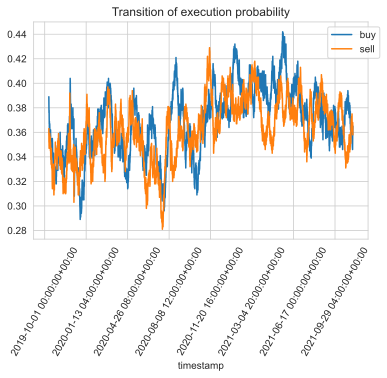

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


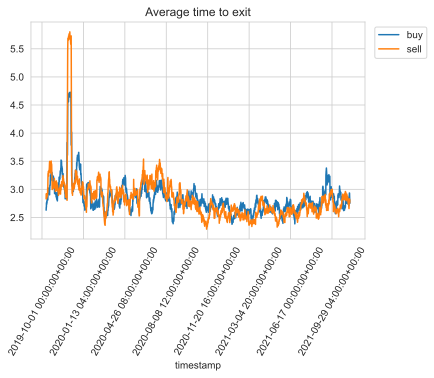

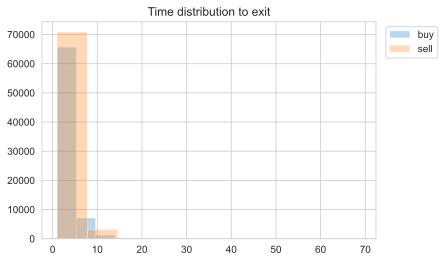

毎時刻、この執行方法でトレードした場合の累積リターン


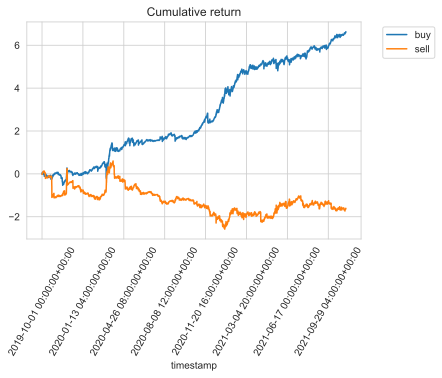

In [20]:
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

df = pd.read_pickle('df_features.pkl')

# 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
pips = 0.5

# ATRで指値距離を計算します
limit_price_dist = df['ATR'] * 0.5
limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

# 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
df['buy_price'] = df['close'] - limit_price_dist
df['sell_price'] = df['close'] + limit_price_dist

# Force Entry Priceの計算
df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['low'].values,
    pips=pips,
)

# calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['high'].values, # 売りのときは高値
    pips=pips,
)
df['sell_fep'] *= -1

horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
fee = df['fee'] # maker手数料

# 指値が約定したかどうか (0, 1)
df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['low'].shift(-1) / pips).round()).astype('float64')
df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['high'].shift(-1) / pips).round()).astype('float64')

# yを計算
df['y_buy'] = np.where(
    df['buy_executed'],
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
df['y_sell'] = np.where(
    df['sell_executed'],
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    0
)

# バックテストで利用する取引コストを計算
df['buy_cost'] = np.where(
    df['buy_executed'],
    df['buy_price'] / df['close'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    df['sell_executed'],
    -(df['sell_price'] / df['close'] - 1) + fee,
    0
)

print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
df['buy_executed'].rolling(1000).mean().plot(label='buy', rot=60)
df['sell_executed'].rolling(1000).mean().plot(label='sell', rot=60)
plt.title('Transition of execution probability')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
df['buy_fet'].rolling(1000).mean().plot(label='buy', rot=60)
df['sell_fet'].rolling(1000).mean().plot(label='sell', rot=60)
plt.title('Average time to exit')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

df['buy_fet'].hist(alpha=0.3, label='buy')
df['sell_fet'].hist(alpha=0.3, label='sell')
plt.title('Time distribution to exit')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

print('毎時刻、この執行方法でトレードした場合の累積リターン')
df['y_buy'].cumsum().plot(label='buy', rot=60)
df['y_sell'].cumsum().plot(label='sell', rot=60)
plt.title('Cumulative return')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('df_y.pkl')

# ML

### 関数定義

In [22]:
def show_lgb_feature_importances(lgb_model):
    ranking = np.argsort(-lgb_model.feature_importances_)  # 重要度のindexを降順で取得
    f, ax = plt.subplots(figsize=(15, 14))
    var_ = []
    for index in ranking:
        var_.append(features[index])
    # x は特徴量の重要度
    # yは特徴量の名前
    sns.barplot(x=lgb_model.feature_importances_[ranking], y =var_, orient='h')
    ax.set_xlabel("lightGBM feature importance")
    plt.tight_layout()
    plt.show()


# p平均法 https://note.com/btcml/n/n0d9575882640
def calc_p_mean(x, n):
    ps = []
    for i in range(n):
        x2 = x[i * x.size // n:(i + 1) * x.size // n]
        if np.std(x2) == 0:
            ps.append(1)
        else:
            t, p = ttest_1samp(x2, 0)
            if t > 0:
                ps.append(p)
            else:
                ps.append(1)
    return np.mean(ps)


def calc_p_mean_type1_error_rate(p_mean, n):
    return (p_mean * n) ** n / math.factorial(n)


def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred

### 学習

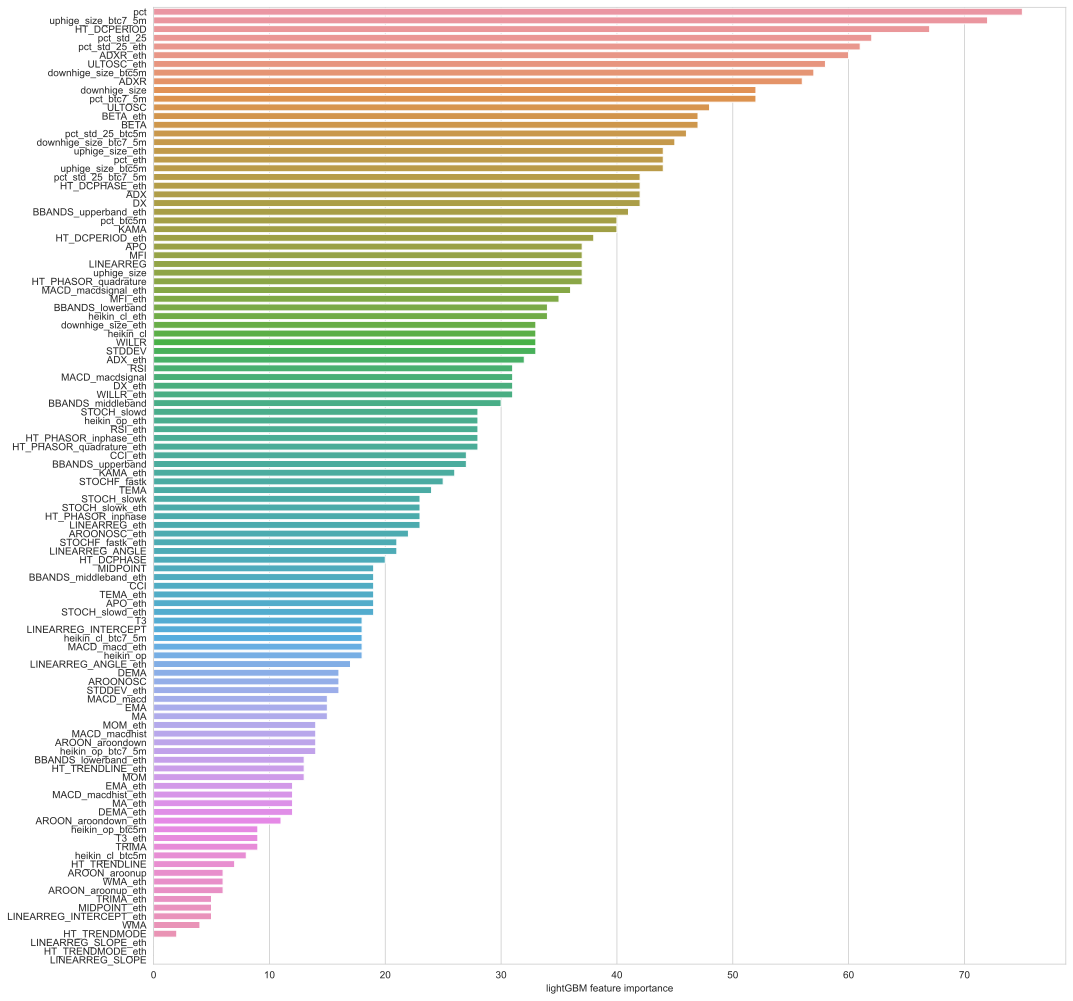

In [23]:
df = pd.read_pickle('df_y.pkl')
df = df.dropna()

# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(boosting_type='gbdt', n_jobs=-1, random_state=1)
# model = lgb.LGBMRegressor(boosting_type='dart', n_jobs=-1, random_state=1)
# model = lgb.LGBMRegressor(boosting_type='goss', n_jobs=-1, random_state=1)

# 通常のCV
cv_indicies = list(KFold().split(df))

df['y_pred_buy'] = my_cross_val_predict(model, df[features].values, df['y_buy'].values, cv=cv_indicies)
df['y_pred_sell'] = my_cross_val_predict(model, df[features].values, df['y_sell'].values, cv=cv_indicies)


# 予測値が無い(nan)行をドロップ
df = df.dropna()

df.to_pickle('df_fit.pkl')

show_lgb_feature_importances(lgb_model=model)

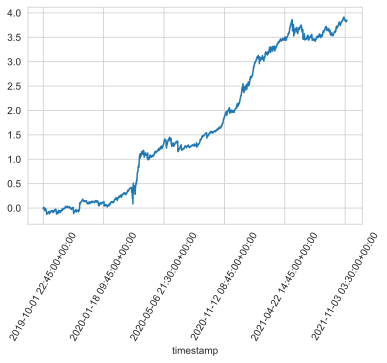

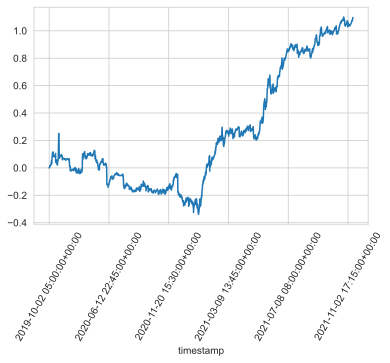

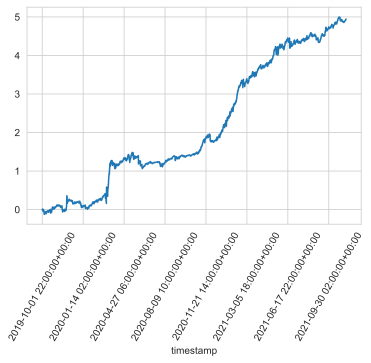

p平均法 n = 5
p平均 0.07202913607093678
エラー率 5.04905154869327e-05


In [26]:
df = pd.read_pickle('df_fit.pkl')

df[(df['y_pred_buy'] > 0) & (df['y_pred_sell'] < 0)]['y_buy'].cumsum().plot(label='buy', rot=60)
plt.show()
df[(df['y_pred_buy'] < 0) & (df['y_pred_sell'] > 0)]['y_sell'].cumsum().plot(label='buy', rot=60)
plt.show()
(df['y_buy'] * ((df['y_pred_buy'] > 0) & (df['y_pred_sell'] < 0)) + df['y_sell'] * ((df['y_pred_buy'] < 0) & (df['y_pred_sell'] > 0))).cumsum().plot(label='buy + sell', rot=60)
plt.show()


df['cum_ret'] = (df['y_buy'] * ((df['y_pred_buy'] > 0) & (df['y_pred_sell'] < 0)) + df['y_sell'] * ((df['y_pred_buy'] < 0) & (df['y_pred_sell'] > 0))).cumsum()
x = df['cum_ret'].diff(1).dropna()
p_mean_n = 5
p_mean = calc_p_mean(x, p_mean_n)
print('p平均法 n = {}'.format(p_mean_n))
print('p平均 {}'.format(p_mean))
print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))

# Test(チューニングなし)

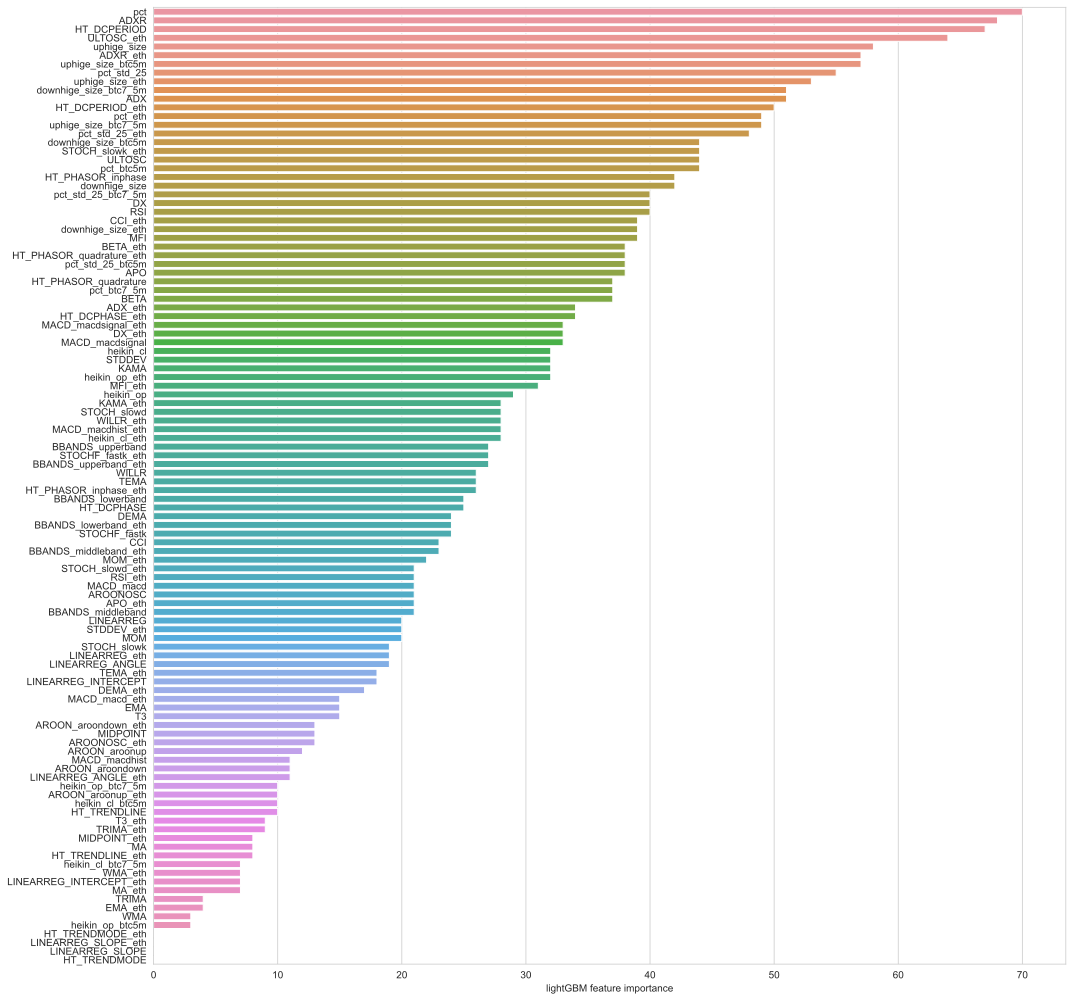

In [40]:
df = pd.read_pickle('df_y.pkl')
df = df.dropna()
df = df.reset_index()

train_ratio = 0.65
df_train = df.loc[:len(df)*train_ratio]
df_test = df.loc[len(df)*train_ratio + 5:]


# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(boosting_type='gbdt', n_jobs=-1, random_state=1)
# model = lgb.LGBMRegressor(boosting_type='dart', n_jobs=-1, random_state=1)
# model = lgb.LGBMRegressor(boosting_type='goss', n_jobs=-1, random_state=1)

def model_predict(estimator, X_train, y_train, X_test):
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    return y_pred

df = df_test.copy()

df['y_pred_buy'] = model_predict(model, df_train[features].values, df_train['y_buy'].values, df_test[features])
df['y_pred_sell'] = model_predict(model, df_train[features].values, df_train['y_sell'].values, df_test[features])

# 予測値が無い(nan)行をドロップ
df = df.dropna().set_index('timestamp')
df.to_pickle('df_fit_test.pkl')
show_lgb_feature_importances(lgb_model=model)

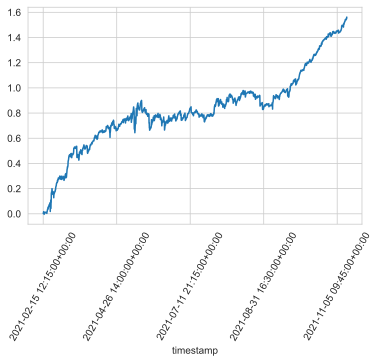

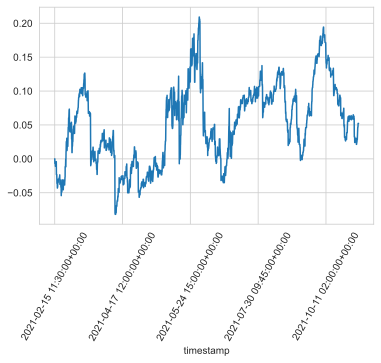

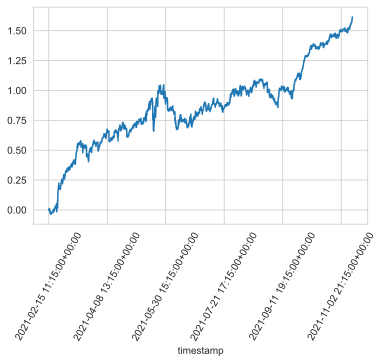

p平均法 n = 5
p平均 0.39828791505830136
エラー率 0.26100836211712836


In [41]:
df = pd.read_pickle('df_fit_test.pkl')

df[(df['y_pred_buy'] > 0) & (df['y_pred_sell'] < 0)]['y_buy'].cumsum().plot(label='buy', rot=60)
plt.show()
df[(df['y_pred_buy'] < 0) & (df['y_pred_sell'] > 0)]['y_sell'].cumsum().plot(label='buy', rot=60)
plt.show()
(df['y_buy'] * ((df['y_pred_buy'] > 0) & (df['y_pred_sell'] < 0)) + df['y_sell'] * ((df['y_pred_buy'] < 0) & (df['y_pred_sell'] > 0))).cumsum().plot(label='buy + sell', rot=60)
plt.show()


df['cum_ret'] = (df['y_buy'] * ((df['y_pred_buy'] > 0) & (df['y_pred_sell'] < 0)) + df['y_sell'] * ((df['y_pred_buy'] < 0) & (df['y_pred_sell'] > 0))).cumsum()
x = df['cum_ret'].diff(1).dropna()
p_mean_n = 5
p_mean = calc_p_mean(x, p_mean_n)
print('p平均法 n = {}'.format(p_mean_n))
print('p平均 {}'.format(p_mean))
print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))

# ハイパーパラメータチューニング

In [35]:
df = pd.read_pickle('df_y.pkl')
df = df.dropna()
df = df.reset_index()

train_ratio = 0.65
df_train = df.loc[:len(df)*train_ratio]
df_test = df.loc[len(df)*train_ratio + 5:]

cv_indicies = list(KFold().split(df_train))

def calc_objective_p(df):
    df = df.copy()
    df['cum_ret'] = (df['y_buy'] * ((df['y_pred_buy'] > 0) & (df['y_pred_sell'] < 0)) + df['y_sell'] * ((df['y_pred_buy'] < 0) & (df['y_pred_sell'] > 0))).cumsum()
    x = df['cum_ret'].diff(1).dropna()
    p_mean_n = 5
    p_mean = calc_p_mean(x, p_mean_n)
    return p_mean


def objectives(trial):
    #==== 最適化したいパラメータ ====
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0)
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0)
    learning_rate = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    subsample = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    min_child_samples = trial.suggest_int('min_child_samples', 5, 50)
    max_depth = trial.suggest_int('max_depth', 5, 15)
    params = {
        "reg_alpha": reg_alpha,
        "reg_lambda": reg_lambda,
        "learning_rate": learning_rate,
        "colsample_bytree": colsample_bytree,
        "subsample" : subsample,
        "min_child_samples": min_child_samples,
        "max_depth": max_depth}

    model = lgb.LGBMRegressor(boosting_type='gbdt', random_state=1, **params)

    def calc_objective_pred(df_train):
        df_train = df_train.copy()
        df_train['y_pred_buy'] = my_cross_val_predict(model, df_train[features].values, df_train['y_buy'].values, cv=cv_indicies)
        df_train['y_pred_sell'] = my_cross_val_predict(model, df_train[features].values, df_train['y_sell'].values, cv=cv_indicies)
        return df_train

    df = calc_objective_pred(df_train=df_train)
    p_mean = calc_objective_p(df=df)
    return p_mean


sampler = optuna.samplers.TPESampler(seed=1)
study = optuna.create_study(sampler=sampler)
study.optimize(objectives, n_trials=100)

best_params = study.best_params
best_score = study.best_value

print('best score: {0}\nbest params: {1}'.format(best_score, best_params))

[I 2021-12-19 15:53:38,306] A new study created in memory with name: no-name-976c2c64-60af-4977-853e-21be23157fe2
[I 2021-12-19 15:53:48,890] Trial 0 finished with value: 0.21450416899063787 and parameters: {'reg_alpha': 5.6649755830282306e-05, 'reg_lambda': 0.030403280126677572, 'learning_rate': 0.1001029373356104, 'min_child_samples': 18, 'max_depth': 6}. Best is trial 0 with value: 0.21450416899063787.
[I 2021-12-19 15:54:08,247] Trial 1 finished with value: 0.3556065681394784 and parameters: {'reg_alpha': 6.777153976882678e-08, 'reg_lambda': 4.746154837062843e-07, 'learning_rate': 0.411004654338743, 'min_child_samples': 23, 'max_depth': 10}. Best is trial 0 with value: 0.21450416899063787.
[I 2021-12-19 15:54:26,156] Trial 2 finished with value: 0.39558379944055405 and parameters: {'reg_alpha': 5.925849666609232e-05, 'reg_lambda': 0.01468843425028415, 'learning_rate': 0.2840070247583657, 'min_child_samples': 45, 'max_depth': 5}. Best is trial 0 with value: 0.21450416899063787.
[I 2

best score: 0.05547535418308143
best params: {'reg_alpha': 2.892969677621095, 'reg_lambda': 1.2363787808770323e-06, 'learning_rate': 0.5082588566669627, 'min_child_samples': 41, 'max_depth': 13}


In [42]:
best_params

{'reg_alpha': 2.892969677621095,
 'reg_lambda': 1.2363787808770323e-06,
 'learning_rate': 0.5082588566669627,
 'min_child_samples': 41,
 'max_depth': 13}

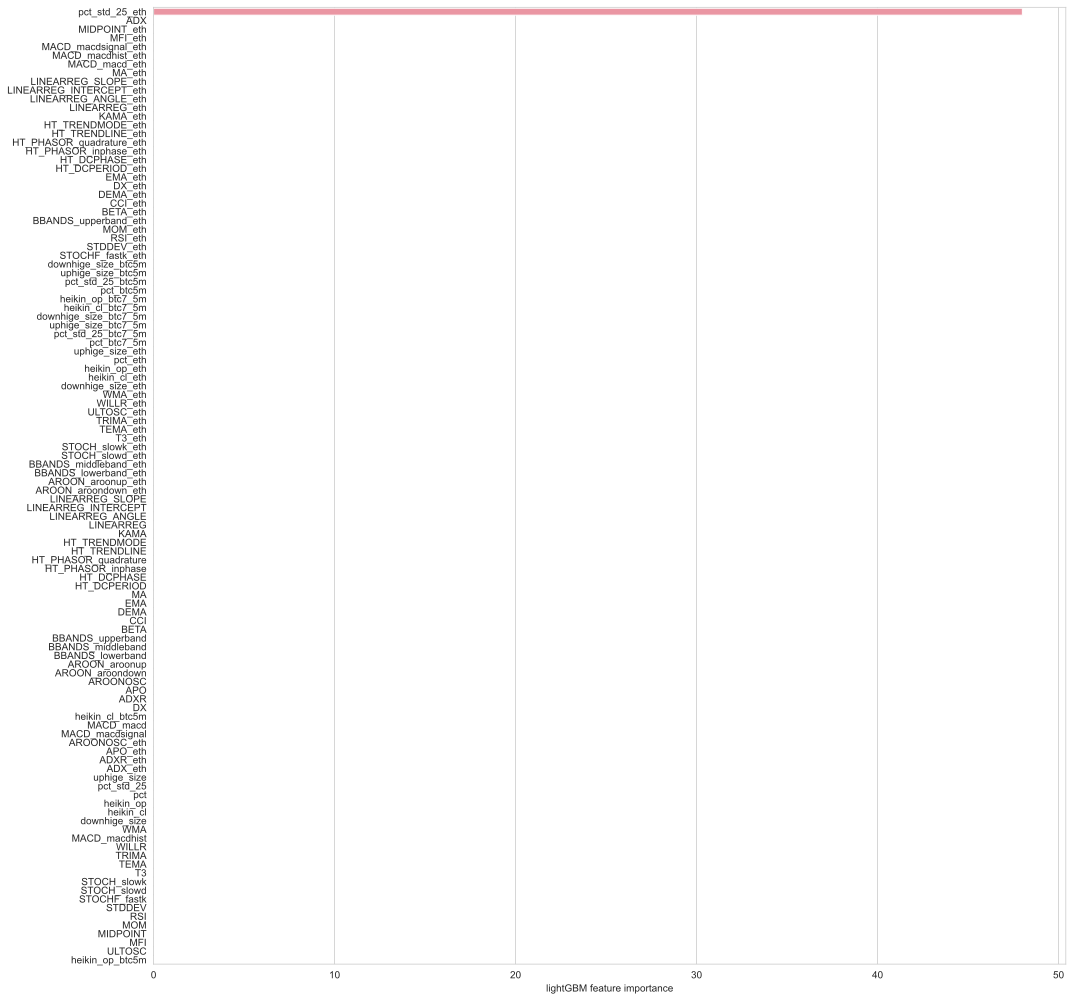

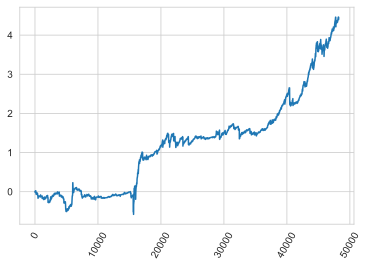

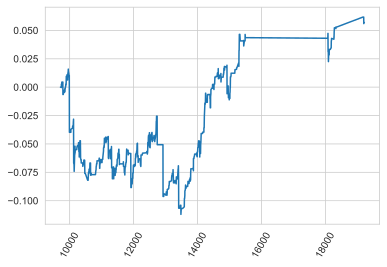

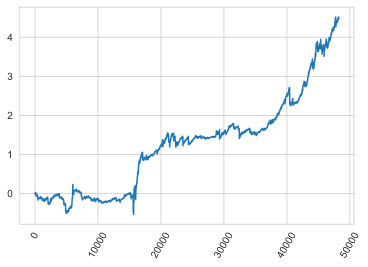

p平均法 n = 5
p平均 0.2551340167347038
エラー率 0.028152087779878272


In [45]:
df = pd.read_pickle('df_y.pkl')
df = df.dropna()
df = df.reset_index()

train_ratio = 0.65
df_train = df.loc[:len(df)*train_ratio]
df_test = df.loc[len(df)*train_ratio + 5:]


# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(boosting_type='gbdt', random_state=1, **best_params)
# model = lgb.LGBMRegressor(boosting_type='dart', n_jobs=-1, random_state=1)
# model = lgb.LGBMRegressor(boosting_type='goss', n_jobs=-1, random_state=1)

def model_predict(estimator, X_train, y_train, X_test):
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    return y_pred

df = df_test.copy()

df['y_pred_buy'] = model_predict(model, df_train[features].values, df_train['y_buy'].values, df_test[features])
df['y_pred_sell'] = model_predict(model, df_train[features].values, df_train['y_sell'].values, df_test[features])

# 予測値が無い(nan)行をドロップ
df = df.dropna().set_index('timestamp')
df.to_pickle('df_fit_test_opt.pkl')
show_lgb_feature_importances(lgb_model=model)


cv_indicies = list(KFold().split(df_train))
df_train = df_train.copy()
df_train['y_pred_buy'] = my_cross_val_predict(model, df_train[features].values, df_train['y_buy'].values, cv=cv_indicies)
df_train['y_pred_sell'] = my_cross_val_predict(model, df_train[features].values, df_train['y_sell'].values, cv=cv_indicies)

df = df_train.copy()

df[(df['y_pred_buy'] > 0) & (df['y_pred_sell'] < 0)]['y_buy'].cumsum().plot(label='buy', rot=60)
plt.show()
df[(df['y_pred_buy'] < 0) & (df['y_pred_sell'] > 0)]['y_sell'].cumsum().plot(label='buy', rot=60)
plt.show()
(df['y_buy'] * ((df['y_pred_buy'] > 0) & (df['y_pred_sell'] < 0)) + df['y_sell'] * ((df['y_pred_buy'] < 0) & (df['y_pred_sell'] > 0))).cumsum().plot(label='buy + sell', rot=60)
plt.show()


df['cum_ret'] = (df['y_buy'] * ((df['y_pred_buy'] > 0) & (df['y_pred_sell'] < 0)) + df['y_sell'] * ((df['y_pred_buy'] < 0) & (df['y_pred_sell'] > 0))).cumsum()
x = df['cum_ret'].diff(1).dropna()
p_mean_n = 5
p_mean = calc_p_mean(x, p_mean_n)
print('p平均法 n = {}'.format(p_mean_n))
print('p平均 {}'.format(p_mean))
print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))

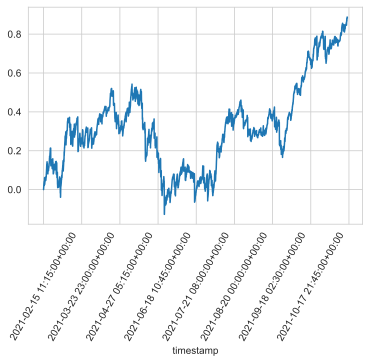

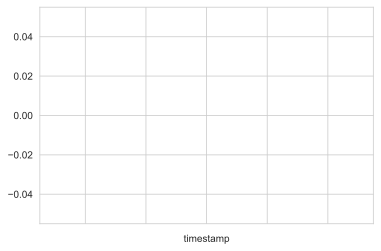

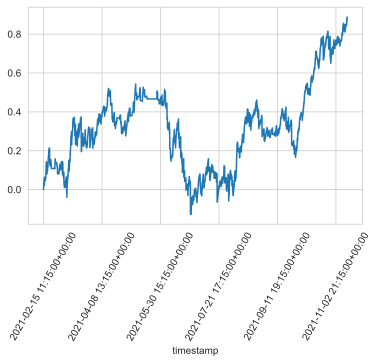

p平均法 n = 5
p平均 0.37294401409553063
エラー率 0.18788278118928317


In [39]:
df = pd.read_pickle('df_fit_test_opt.pkl')

df[(df['y_pred_buy'] > 0) & (df['y_pred_sell'] < 0)]['y_buy'].cumsum().plot(label='buy', rot=60)
plt.show()
df[(df['y_pred_buy'] < 0) & (df['y_pred_sell'] > 0)]['y_sell'].cumsum().plot(label='buy', rot=60)
plt.show()
(df['y_buy'] * ((df['y_pred_buy'] > 0) & (df['y_pred_sell'] < 0)) + df['y_sell'] * ((df['y_pred_buy'] < 0) & (df['y_pred_sell'] > 0))).cumsum().plot(label='buy + sell', rot=60)
plt.show()


df['cum_ret'] = (df['y_buy'] * ((df['y_pred_buy'] > 0) & (df['y_pred_sell'] < 0)) + df['y_sell'] * ((df['y_pred_buy'] < 0) & (df['y_pred_sell'] > 0))).cumsum()
x = df['cum_ret'].diff(1).dropna()
p_mean_n = 5
p_mean = calc_p_mean(x, p_mean_n)
print('p平均法 n = {}'.format(p_mean_n))
print('p平均 {}'.format(p_mean))
print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))

# ハイパーパラメーターチューニング２

In [52]:
df = pd.read_pickle('df_y.pkl')
df = df.dropna()
df = df.reset_index()

train_ratio = 0.65
df_train = df.loc[:len(df)*train_ratio]
df_test = df.loc[len(df)*train_ratio + 5:]

cv_indicies = list(KFold().split(df_train))


def calc_objective_p(df):
    df = df.copy()
    df['cum_ret'] = df[df['y_pred_buy'] > 0]['y_buy'].cumsum()
    x = df['cum_ret'].diff(1).dropna()
    p_mean_n = 5
    p_mean = calc_p_mean(x, p_mean_n)
    return p_mean


def objectives(trial):
    #==== 最適化したいパラメータ ====
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0)
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0)
    learning_rate = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    subsample = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    min_child_samples = trial.suggest_int('min_child_samples', 5, 50)
    max_depth = trial.suggest_int('max_depth', 5, 15)
    params = {
        "reg_alpha": reg_alpha,
        "reg_lambda": reg_lambda,
        "learning_rate": learning_rate,
        "colsample_bytree": colsample_bytree,
        "subsample" : subsample,
        "min_child_samples": min_child_samples,
        "max_depth": max_depth}

    buy_model = lgb.LGBMRegressor(boosting_type='gbdt', random_state=1, **params)

    def calc_objective_pred(df_train):
        df_train = df_train.copy()
        df_train['y_pred_buy'] = my_cross_val_predict(buy_model, df_train[features].values, df_train['y_buy'].values, cv=cv_indicies)
        return df_train

    df = calc_objective_pred(df_train=df_train)
    p_mean = calc_objective_p(df=df)
    return p_mean


sampler = optuna.samplers.TPESampler(seed=1)
study = optuna.create_study(sampler=sampler)
study.optimize(objectives, n_trials=100)

buy_best_params = study.best_params
buy_best_score = study.best_value

print('best score: {0}\nbest params: {1}'.format(buy_best_score, buy_best_params))

[I 2021-12-19 16:45:42,336] A new study created in memory with name: no-name-91829efd-0a34-489a-b4fa-e1e83ab7482d
[I 2021-12-19 16:45:51,299] Trial 0 finished with value: 0.18153924805810992 and parameters: {'reg_alpha': 5.6649755830282306e-05, 'reg_lambda': 0.030403280126677572, 'learning_rate': 0.1001029373356104, 'min_child_samples': 18, 'max_depth': 6}. Best is trial 0 with value: 0.18153924805810992.
[I 2021-12-19 16:46:02,141] Trial 1 finished with value: 0.31596822616926545 and parameters: {'reg_alpha': 6.777153976882678e-08, 'reg_lambda': 4.746154837062843e-07, 'learning_rate': 0.411004654338743, 'min_child_samples': 23, 'max_depth': 10}. Best is trial 0 with value: 0.18153924805810992.
[I 2021-12-19 16:46:08,395] Trial 2 finished with value: 0.42280247178390884 and parameters: {'reg_alpha': 5.925849666609232e-05, 'reg_lambda': 0.01468843425028415, 'learning_rate': 0.2840070247583657, 'min_child_samples': 45, 'max_depth': 5}. Best is trial 0 with value: 0.18153924805810992.
[I 

best score: 0.010417668592620976
best params: {'reg_alpha': 0.9400218594418958, 'reg_lambda': 2.2160826818540562e-05, 'learning_rate': 0.48945931722631275, 'min_child_samples': 50, 'max_depth': 12}


In [55]:
df = pd.read_pickle('df_y.pkl')
df = df.dropna()
df = df.reset_index()

train_ratio = 0.65
df_train = df.loc[:len(df)*train_ratio]
df_test = df.loc[len(df)*train_ratio + 5:]

cv_indicies = list(KFold().split(df_train))


def calc_objective_p(df):
    df = df.copy()
    df['cum_ret'] = df[df['y_pred_sell'] > 0]['y_sell'].cumsum()
    x = df['cum_ret'].diff(1).dropna()
    p_mean_n = 5
    p_mean = calc_p_mean(x, p_mean_n)
    return p_mean


def objectives(trial):
    #==== 最適化したいパラメータ ====
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0)
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0)
    learning_rate = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    subsample = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    min_child_samples = trial.suggest_int('min_child_samples', 5, 50)
    max_depth = trial.suggest_int('max_depth', 5, 15)
    params = {
        "reg_alpha": reg_alpha,
        "reg_lambda": reg_lambda,
        "learning_rate": learning_rate,
        "colsample_bytree": colsample_bytree,
        "subsample" : subsample,
        "min_child_samples": min_child_samples,
        "max_depth": max_depth}

    sell_model = lgb.LGBMRegressor(boosting_type='gbdt', random_state=1, **params)

    def calc_objective_pred(df_train):
        df_train = df_train.copy()
        df_train['y_pred_sell'] = my_cross_val_predict(sell_model, df_train[features].values, df_train['y_sell'].values, cv=cv_indicies)
        return df_train

    df = calc_objective_pred(df_train=df_train)
    p_mean = calc_objective_p(df=df)
    return p_mean


sampler = optuna.samplers.TPESampler(seed=1)
study = optuna.create_study(sampler=sampler)
study.optimize(objectives, n_trials=100)

sell_best_params = study.best_params
sell_best_score = study.best_value

print('best score: {0}\nbest params: {1}'.format(sell_best_score, sell_best_params))

[I 2021-12-19 17:04:20,881] A new study created in memory with name: no-name-fb7d54c2-ad47-4bac-b959-a78cf99e444a
[I 2021-12-19 17:04:43,407] Trial 0 finished with value: 0.4962229317542152 and parameters: {'reg_alpha': 5.6649755830282306e-05, 'reg_lambda': 0.030403280126677572, 'learning_rate': 0.1001029373356104, 'min_child_samples': 18, 'max_depth': 6}. Best is trial 0 with value: 0.4962229317542152.
[I 2021-12-19 17:05:04,059] Trial 1 finished with value: 0.8939300001044239 and parameters: {'reg_alpha': 6.777153976882678e-08, 'reg_lambda': 4.746154837062843e-07, 'learning_rate': 0.411004654338743, 'min_child_samples': 23, 'max_depth': 10}. Best is trial 0 with value: 0.4962229317542152.
[I 2021-12-19 17:05:16,733] Trial 2 finished with value: 0.7509118615990124 and parameters: {'reg_alpha': 5.925849666609232e-05, 'reg_lambda': 0.01468843425028415, 'learning_rate': 0.2840070247583657, 'min_child_samples': 45, 'max_depth': 5}. Best is trial 0 with value: 0.4962229317542152.
[I 2021-1

best score: 0.22619589572396315
best params: {'reg_alpha': 1.3918294481172828e-05, 'reg_lambda': 0.18816134500474344, 'learning_rate': 0.11746886703767007, 'min_child_samples': 20, 'max_depth': 9}


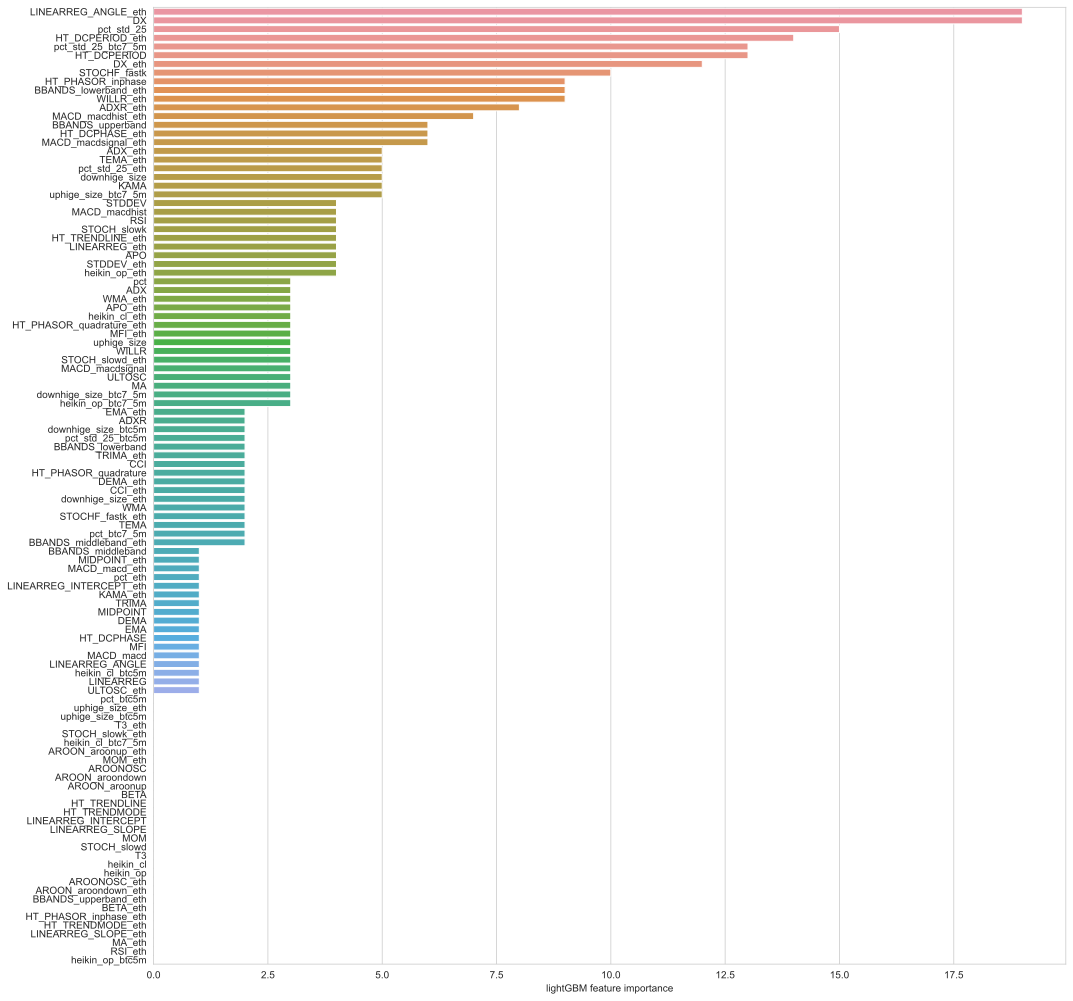

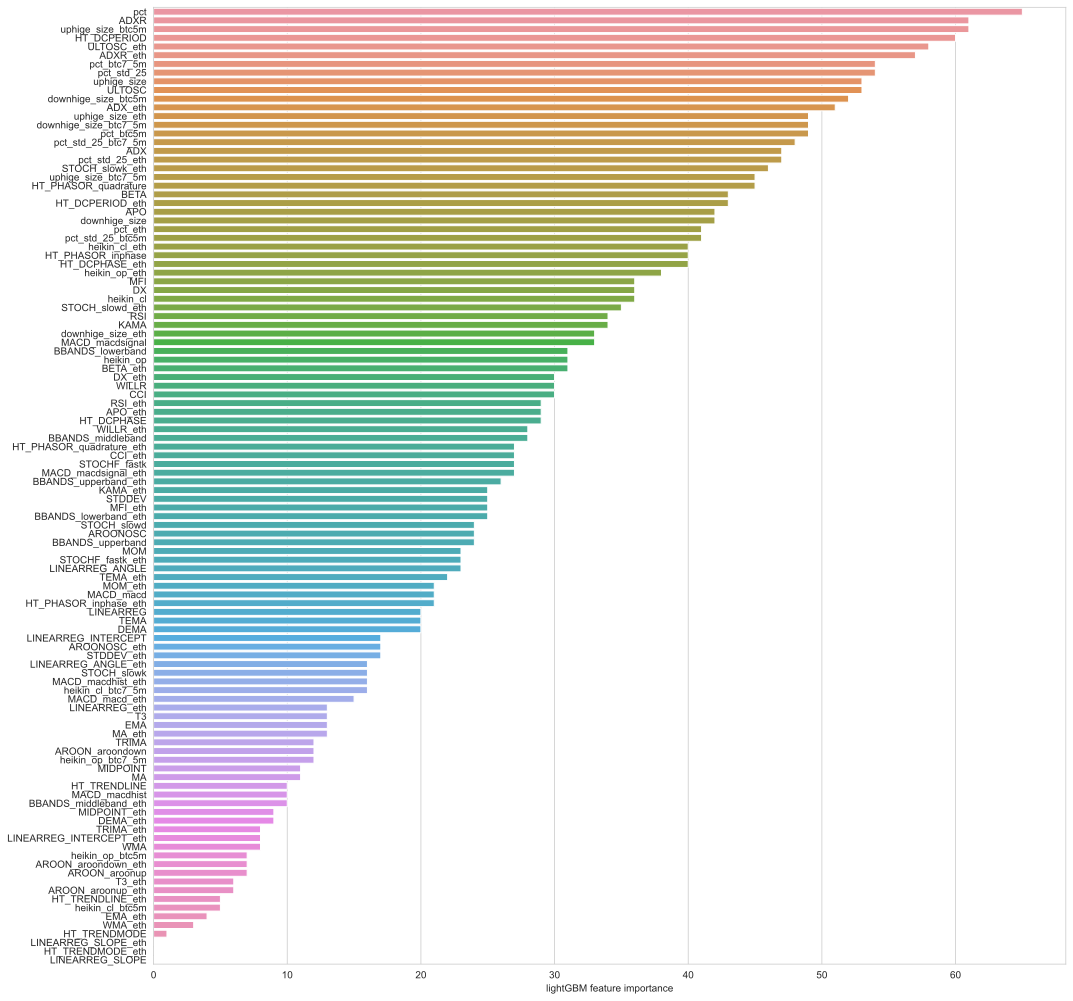

In [58]:
df = pd.read_pickle('df_y.pkl')
df = df.dropna()
df = df.reset_index()

train_ratio = 0.65
df_train = df.loc[:len(df)*train_ratio]
df_test = df.loc[len(df)*train_ratio + 5:]


# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
buy_model = lgb.LGBMRegressor(boosting_type='gbdt', random_state=1, **buy_best_params)
sell_model = lgb.LGBMRegressor(boosting_type='gbdt', random_state=1, **sell_best_params)
# model = lgb.LGBMRegressor(boosting_type='dart', n_jobs=-1, random_state=1)
# model = lgb.LGBMRegressor(boosting_type='goss', n_jobs=-1, random_state=1)

def model_predict(estimator, X_train, y_train, X_test):
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    return y_pred

df = df_test.copy()

df['y_pred_buy'] = model_predict(buy_model, df_train[features].values, df_train['y_buy'].values, df_test[features])
df['y_pred_sell'] = model_predict(sell_model, df_train[features].values, df_train['y_sell'].values, df_test[features])

# 予測値が無い(nan)行をドロップ
df = df.dropna().set_index('timestamp')
df.to_pickle('df_fit_test_opt.pkl')
show_lgb_feature_importances(lgb_model=buy_model)
show_lgb_feature_importances(lgb_model=sell_model)

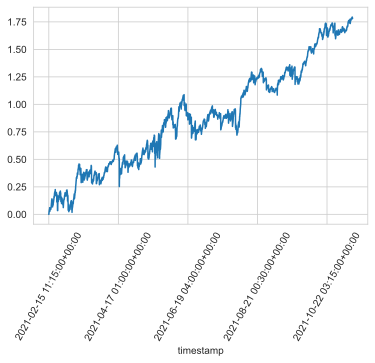

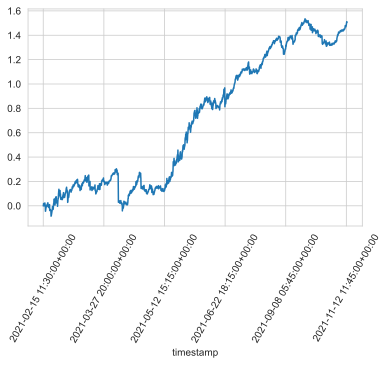

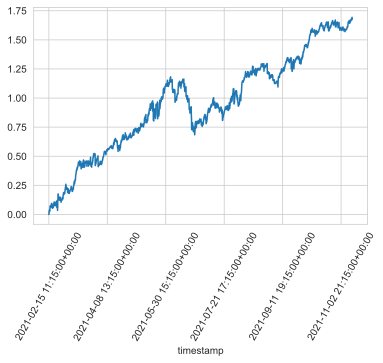

p平均法 n = 5
p平均 0.28589738504295426
エラー率 0.049741593172563124
p平均法 n = 5
p平均 0.47116269551895024
エラー率 0.6046767416809864
p平均法 n = 5
p平均 0.24022974969058142
エラー率 0.020835442074041206


In [59]:
df = pd.read_pickle('df_fit_test_opt.pkl')

df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(label='buy', rot=60)
plt.show()
df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(label='buy', rot=60)
plt.show()
(df['y_buy'] * ((df['y_pred_buy'] > 0) & (df['y_pred_sell'] < 0)) + df['y_sell'] * ((df['y_pred_buy'] < 0) & (df['y_pred_sell'] > 0))).cumsum().plot(label='buy + sell', rot=60)
plt.show()


df['cum_ret'] = df[df['y_pred_buy'] > 0]['y_buy'].cumsum()
x = df['cum_ret'].diff(1).dropna()
p_mean_n = 5
p_mean = calc_p_mean(x, p_mean_n)
print('p平均法 n = {}'.format(p_mean_n))
print('p平均 {}'.format(p_mean))
print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))

df['cum_ret'] = df[df['y_pred_sell'] > 0]['y_sell'].cumsum()
x = df['cum_ret'].diff(1).dropna()
p_mean_n = 5
p_mean = calc_p_mean(x, p_mean_n)
print('p平均法 n = {}'.format(p_mean_n))
print('p平均 {}'.format(p_mean))
print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))

df['cum_ret'] = (df['y_buy'] * ((df['y_pred_buy'] > 0) & (df['y_pred_sell'] < 0)) + df['y_sell'] * ((df['y_pred_buy'] < 0) & (df['y_pred_sell'] > 0))).cumsum()
x = df['cum_ret'].diff(1).dropna()
p_mean_n = 5
p_mean = calc_p_mean(x, p_mean_n)
print('p平均法 n = {}'.format(p_mean_n))
print('p平均 {}'.format(p_mean))
print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))

# 本番

In [ ]:
import time
from datetime import datetime


class Order:
    """注文の情報をもつクラス
    Attributes
    ----------
    side : str = constants.BUY | constants.SELL
        買い、もしくは売り
    order_type : str = constans.LIMIT | constans.MARKET | constans.STOP
        成行、指値、逆指値
    qty : int
        ポジションサイズ
    price : float | None
        注文の値段。成行注文の場合はNoneとする
    created_at : datetime | None
        注文が作成された時刻。注文を出す際はNoneと指定
    updated_at : datetime | None
        注文が更新された時刻。注文を出す際はNoneと指定
    """
    def __init__(
            self, 
            side: str, 
            order_type: str, 
            qty: int, 
            price: Union[float, None], 
            created_at: Union[datetime, None] = None,
            updated_at: Union[datetime, None] = None) -> None:
        self.side : str = side
        self.order_type : str = order_type
        self.qty : int = qty
        self.price : Union[float, None] = price
        self.created_at : Union[datetime, None] = created_at
        self.updated_at : Union[datetime, None] = updated_at

    def __str__(self) -> str:
        return str(self.__dict__)


class ApiClient:
    def cancel_all_active_orders(self):
        pass

    def get_active_orders(self):
        pass

    def get_ohlcs(self, time_interval: str = None, num_ohlcs: int = None):
        pass

    def get_position():
        pass

    def create_order(self, order: Order):
        pass


def calc_features(df):
    pass


def start(api_client: ApiClient, qty, interval):
    while True:
        dt_now = datetime.now()
        
        #15分ごとに実行
        if dt_now.minute % interval == 0:
            try:
                #全注文をキャンセル
                api_client.cancel_all_active_orders()
                #有効注文がなくなるまで待機
                while True:
                    orders = api_client.get_active_orders()
                    if len(orders) == 0:
                        break
                    time.sleep(1)

                ohlcs = api_client.get_ohlcs()
                df_ohlcs = pd.DataFrame([ohlc.__dict__ for ohlc in ohlcs])
                df_features = calc_features(df_ohlcs)

                #モデル読み込み
                model_y_buy = joblib.load('./model/model_y_buy.xz')
                model_y_sell = joblib.load('./model/model_y_sell.xz')

                #推論
                df_features["y_pred_buy"] = model_y_buy.predict(df_features[features])
                df_features["y_pred_sell"] = model_y_sell.predict(df_features[features])

                df_features["buy_price"] = df_features["cl"] - df_features["ATR"] * 0.5
                df_features["sell_price"] = df_features["cl"] + df_features["ATR"] * 0.5

                pred_buy = df_features["y_pred_buy"].iloc[-1]
                pred_sell = df_features["y_pred_sell"].iloc[-1]

                buy_price = int(df_features["buy_price"].iloc[-1])  # 0.5刻みにする必要あり？
                sell_price = int(df_features["sell_price"].iloc[-1])

                now_position = api_client.get_position()
                # entry
                if now_position.side == 'None':
                    if pred_buy > 0:
                        order = Order(side='Buy', order_type='Limit', qty=qty, price=buy_price)
                        api_client.create_order(order=order)
                    if pred_sell > 0:
                        order = Order(side='Sell', order_type='Limit', qty=qty, price=sell_price)
                        api_client.create_order(order=order)
                # exit
                elif now_position.side == 'Buy':
                    if not (pred_sell < 0 and pred_buy > 0):  # 予測がまだ上がる場合は保留
                        order = Order(side='Sell', order_type='Limit', qty=now_position.size, price=sell_price)
                        api_client.create_order(order=order)
                elif now_position == 'Sell':
                    if not (pred_buy < 0 and pred_sell > 0):  # 予測がまだ下がる場合は保留
                        order = Order(side='Buy', order_type='Limit', qty=now_position.size, price=buy_price)
                        api_client.create_order(order=order)


            except Exception as e:
                print(e)
                pass
